# Demonstration laps analysis
In this notebook we look in details each lap of the demonstration set to select the best laps to use for the behavioural cloning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
demos = pd.read_csv('../demonstrations/extracted_features/demonstrations.csv')

In [3]:
ref = pd.read_csv('../demonstrations/extracted_features/ref_traj.csv')

In [4]:
ref.columns

Index(['curLapTime', 'Dist', 'Acceleration_x', 'Acceleration_y', 'Gear', 'rpm',
       'speed_x', 'speed_y', 'speed_z', 'dist_to_middle', 'xCarWorld',
       'yCarWorld', 'z', 'roll', 'pitch', 'yaw', 'speedGlobalX',
       'speedGlobalY', 'Steer', 'Throttle', 'Brake', 'NLap', 'is_partial',
       'isReference', 'trackPos'],
      dtype='object')

In [5]:
ref_time = ref.curLapTime.values[-1]
ref_time

73.863997

In [6]:
demos.shape

(56192, 30)

In [7]:
len(set(demos.NLap))

82

In [8]:
demos.columns

Index(['NLap', 'is_partial', 'isReference', 'trackPos', 'time', 'NGear',
       'nEngine', 'xCarWorld', 'yCarWorld', 'nYawBody', 'aSteerWheel',
       'rThrottlePedal', 'pBrakeF', 'acceleration_x', 'acceleration_y',
       'speed_x', 'speed_y', 'prevaSteerWheel', 'prevpBrakeF',
       'prevrThrottlePedal', 'direction_x', 'direction_y', 'delta_speed_x',
       'delta_speed_y', 'delta_acc_x', 'delta_acc_y', 'delta_direction_x',
       'delta_direction_y', 'positionRho', 'positionTheta'],
      dtype='object')

In [9]:
laps = set(demos.NLap)

In [10]:
lap_times = [max(demos[demos.NLap == lap].time) for lap in laps]

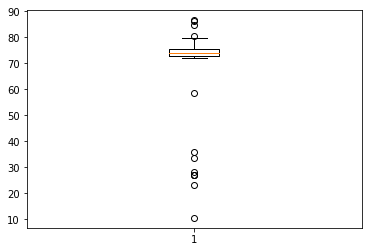

In [11]:
plt.boxplot(lap_times);

Take only the partial laps that corresponds to a start from still car i.e., low initial speed.

In [12]:
slow_laps = [lap for i, lap in enumerate(laps) if lap_times[i] < 65]

In [13]:
slow_laps

[0, 5, 6, 7, 8, 9, 45, 47, 69]

Print speed profile during the partial lap to identify the right laps

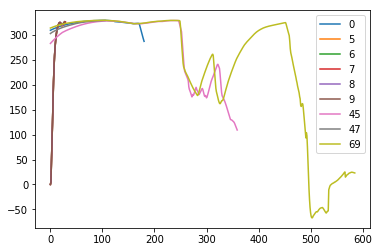

In [14]:
for lap in slow_laps:
    plt.plot(demos[demos.NLap == lap].speed_x.values, label=lap);
plt.legend();

In [15]:
start_laps = list(filter(lambda lap: demos[demos.NLap == lap].speed_x.values[0] < 20, slow_laps))

In [16]:
start_laps

[5, 6, 7, 8, 9]

In [17]:
bad_laps = [lap for lap in slow_laps if lap not in start_laps]

In [18]:
bad_laps

[0, 45, 47, 69]

We use as demonstration laps the ones that have a time near to the reference trajectory time i.e., around 70s plus the start laps.

In [19]:
good_laps = []
good_lap_times = []
for lap, time in zip(laps, lap_times):
    if abs(time - ref_time) < ref_time * 0.02:
        good_laps.append(lap)
        good_lap_times.append(time)
    elif lap in start_laps:
        good_laps.append(lap)
        good_lap_times.append(time)

In [20]:
len(good_laps)

50

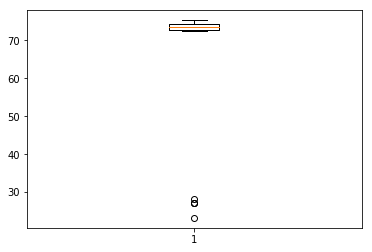

In [21]:
plt.boxplot(good_lap_times);

Plot the trajectories of each lap

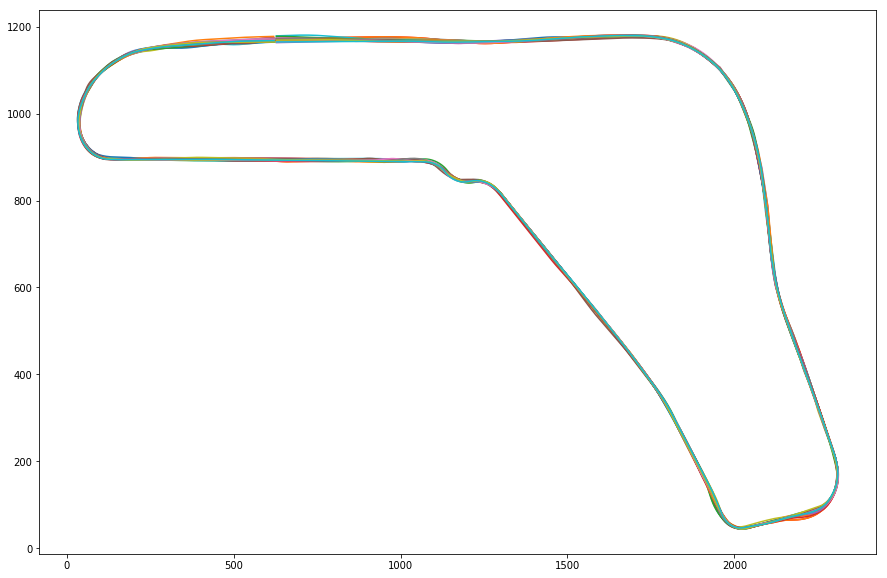

In [22]:
plt.figure(figsize=(15, 10))
plt.plot(ref.xCarWorld, ref.yCarWorld, 'r')
for lap in good_laps:
    demos_lap = demos[demos.NLap == lap]
    plt.plot(demos_lap.xCarWorld, demos_lap.yCarWorld);

Save the demonstrations as a new csv file

In [ ]:
demos[demos.NLap.isin(good_laps)].to_csv('../demonstrations/extracted_features/top_demonstrations.csv',
                                         index=False)

# State dimension analysis
We check the dimension boundaries for each state feature to be used for the normalization by the RL algorithms

In [37]:
good_demos = demos[demos.NLap.isin(good_laps)]

In [27]:
ref.columns

Index(['curLapTime', 'Dist', 'Acceleration_x', 'Acceleration_y', 'Gear', 'rpm',
       'speed_x', 'speed_y', 'speed_z', 'dist_to_middle', 'xCarWorld',
       'yCarWorld', 'z', 'roll', 'pitch', 'yaw', 'speedGlobalX',
       'speedGlobalY', 'Steer', 'Throttle', 'Brake', 'NLap', 'is_partial',
       'isReference', 'trackPos'],
      dtype='object')

In [26]:
demos.describe().loc[['min', 'max']].T

,min,max
NLap,0.000000,91.000000
trackPos,-2.224511,7.464206
time,-0.902000,86.607993
NGear,-1.000000,7.000000
nEngine,5235.988160,20178.295900
xCarWorld,13.553574,2312.452148
yCarWorld,42.591827,1182.149170
nYawBody,-3.141584,3.141590
aSteerWheel,-0.843328,0.930453
rThrottlePedal,0.000000,1.000000


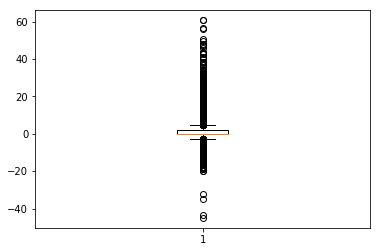

In [38]:
plt.boxplot(good_demos.speed_y);

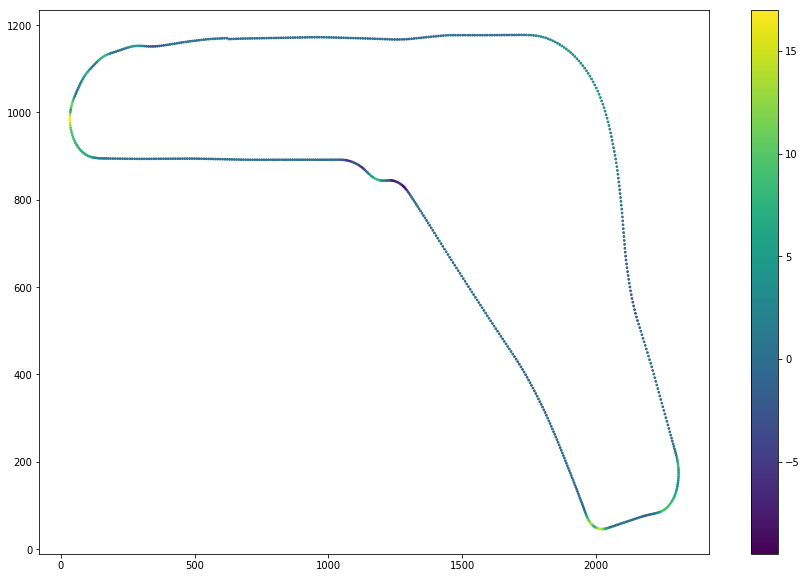

In [44]:
plt.figure(figsize=(15,10))
plt.scatter(good_demos[good_demos.NLap == 3].xCarWorld,
           good_demos[good_demos.NLap == 3].yCarWorld,
           c=good_demos[good_demos.NLap == 3].speed_y, s=3)
plt.colorbar();

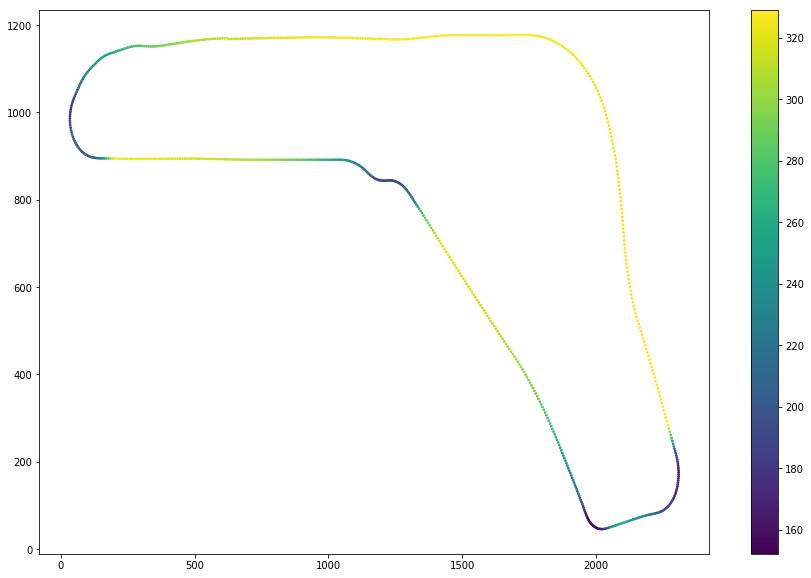

In [45]:
plt.figure(figsize=(15,10))
plt.scatter(good_demos[good_demos.NLap == 3].xCarWorld,
           good_demos[good_demos.NLap == 3].yCarWorld,
           c=good_demos[good_demos.NLap == 3].speed_x, s=3)
plt.colorbar();

In [ ]:
state = {'xCarWorld': {'low': 0, 'high': 2500}, 'yCarWorld': {'low': 0, 'high': 1200},
         'nYawBody': {'low': -np.pi, 'high': np.pi}, 'nEngine': {'low': 0, 'high': 21000},
         'positionRho': {'low': 0, 'high': 50}, 'positionTheta': {'low': -np.pi, 'high': np.pi},
         'speed_x': {'low': 0, 'high': 340}, 'speed_y': {'low': -90, 'high': 160},
         'acceleration_x': {'low': -50, 'high': 50}, 'acceleration_y': {'low': -75, 'high': 85},
         'direction_x': {'low': -1, 'high': 1}, 'direction_y': {'low': -1, 'high': 1},
         'NGear': {'low': 0, 'high': 7}, 'prevaSteerWheel': {'low': -1, 'high': 1},
         'prevpBrakeF': {'low': 0, 'high': 1}, 'prevrThrottlePedal': {'low': 0, 'high': 1},
         'delta_speed_x': {'low': -340, 'high': 340}, 'delta_speed_y': {'low': -250, 'high': 250},
         'delta_acc_x': {'low': -100, 'high': 100}, 'delta_acc_y': {'low': -160, 'high': 160},
         'delta_direction_x': {'low': -1, 'high': 1}, 'delta_direction_y': {'low': -1, 'high': 1}}

state_cols = list(state.keys())
state_space = {'high': np.array([state[k]['high'] for k in state_cols]),
               'low': np.array([state[k]['low'] for k in state_cols])}